In [27]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Added ReduceLROnPlateau for learning rate scheduling
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from typing import Literal
from pathlib import Path
from PIL import Image

In [2]:
X = np.load("X_128x128.npy", allow_pickle=True)
y = np.load("y_128x128.npy", allow_pickle=True)
np.sum(y, axis=0)

array([1315, 15476, 3873], dtype=object)

In [16]:
# Assuming y is one-hot encoded with 3 classes: 
# y = [[1, 0, 0],  # COVID
#      [0, 1, 0],  # Healthy
#      [0, 0, 1]]  # Symptomatic

# Step 1: Convert y to integer labels (0 for COVID, 1 for Healthy, 2 for Symptomatic)
y_combined = np.argmax(y, axis=1)  # This will give us an array of indices: 0, 1, or 2

# Step 2: Combine symptomatic (class 2) and COVID (class 0) into one category (class 1), leave healthy (class 1) as it is
new_y = np.where(np.isin(y_combined, [0, 2]), 1, 0)  # Map COVID and Symptomatic to class 1, healthy to class 0

# Step 3: Convert the new labels to one-hot encoding (2 classes: healthy vs symptomatic or COVID)
new_y = np.array([[1, 0] if label == 0 else [0, 1] for label in new_y])

# Verify the shape of the new y
print(f"new_y shape: {new_y.shape}")  # It should be (n_samples, 2)

# Check the first few rows of the new_y to confirm it's correct
print(new_y[:10])  # Display the first 10 rows to check

new_y shape: (20664, 2)
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


In [22]:
# Sum the COVID
covid_and_symptomatic_sum = np.sum(new_y[:,1])

print(f"Total number of COVID or symptomatic cases: {covid_and_symptomatic_sum}")

# Sum the Healthy 
healthy_sum = np.sum(new_y[:,0])

print(f"Total number of healthy cases: {healthy_sum}")

Total number of COVID or symptomatic cases: 5188
Total number of COVID or symptomatic cases: 15476


In [17]:
# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, new_y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42
)

# === Convert X and y to appropriate formats ===
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [28]:
# === Calculate Class Weights ===
class_weights = compute_class_weight(
    class_weight='balanced',  # Automatically compute the class weights
    classes=np.unique(np.argmax(y_train, axis=1)),  # Classes should be 0 for healthy, 1 for symptomatic or COVID
    y=np.argmax(y_train, axis=1)  # Convert y_train to integer labels
)

class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

# === CNN Model Definition ===
model = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Global Average Pooling instead of Flattening
    GlobalAveragePooling2D(),
    
    # Dropout to prevent overfitting
    Dropout(0.5),  # Increase dropout

    # Fully Connected Layer
    Dense(128, activation='relu'),
    
    # Output Layer (2 classes: healthy and symptomatic_or_COVID)
    Dense(2, activation='softmax')
])

# === Compile the model ===
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# === Early Stopping Callback ===
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=7,  # Patience increased to 7 epochs
    restore_best_weights=True
)

# === Learning Rate Scheduling ===
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3,  # Reduce learning rate by 30%
    patience=2,  # Wait for 2 epochs without improvement before reducing LR
    min_lr=1e-6  # Lower bound for the learning rate
)

# === Train the Model with Class Weights ===
history = model.fit(
    X_train, y_train,
    epochs=30,  # Use a higher number of epochs to allow the model to learn better
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights_dict,  # Pass class weights here
    callbacks=[early_stopping, reduce_lr]
)

# === Evaluate Model ===
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2%}")

Class Weights: {0: 0.6675955092480413, 1: 1.9916867469879518}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 81s 171ms/step - accuracy: 0.5007 - loss: 0.7326 - val_accuracy: 0.2491 - val_loss: 0.7195 - learning_rate: 5.0000e-04
Epoch 2/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 78s 168ms/step - accuracy: 0.5269 - loss: 0.6931 - val_accuracy: 0.2600 - val_loss: 0.7122 - learning_rate: 5.0000e-04
Epoch 3/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - accuracy: 0.4856 - loss: 0.6982 - val_accuracy: 0.5459 - val_loss: 0.6912 - learning_rate: 5.0000e-04
Epoch 4/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - accuracy: 0.5129 - loss: 0.6933 - val_accuracy: 0.5308 - val_loss: 0.6883 - learning_rate: 5.0000e-04
Epoch 5/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - accuracy: 0.4930 - loss: 0.6938 - val_accuracy: 0.7213 - val_loss: 0.6539 - learning_rate: 5.0000e-04
Epoch 6/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 81s 173ms/step - accuracy: 0.5313 - loss: 0.6908 - val_accuracy: 0.3930 - val_loss: 0.7091 - learning_rate: 5.0000e-04
Epoch 7/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 80s 17

130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
Classification Report:
                      precision    recall  f1-score   support

             healthy       0.75      0.92      0.83      3095
symptomatic or COVID       0.29      0.09      0.14      1038

            accuracy                           0.72      4133
           macro avg       0.52      0.51      0.49      4133
        weighted avg       0.64      0.72      0.66      4133



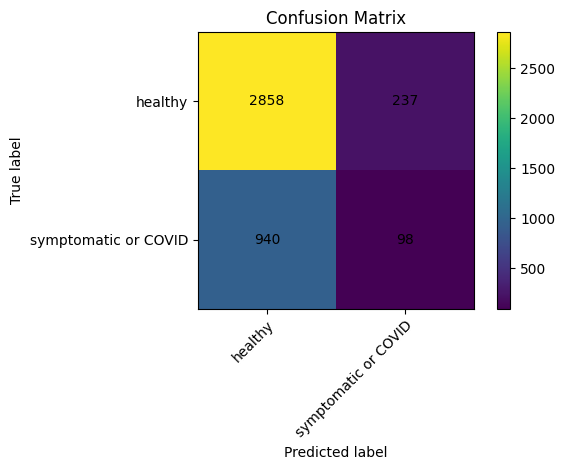

In [29]:
# === Evaluate the Model ===
# Get predictions from the model
y_pred = model.predict(X_test)  # Predict on X_test
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class predictions (argmax for the softmax output)

# Convert y_test from one-hot encoding to integer labels (healthy = 0, COVID/symptomatic = 1)
y_test_classes = np.argmax(y_test, axis=1)

# === Compute confusion matrix ===
cm = confusion_matrix(y_test_classes, y_pred_classes)

# === Print classification report ===
print("Classification Report:")
print(classification_report(
    y_test_classes,
    y_pred_classes,
    target_names=['healthy', 'symptomatic or COVID']
))

# === (Optional) Plot the confusion matrix ===
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

# Define the class labels
classes = ['healthy', 'symptomatic or COVID']
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Predicted label',
    ylabel='True label',
    title='Confusion Matrix'
)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate counts in each cell of the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [31]:
# === Calculate Class Weights ===
class_weights = {0: .6, 1: 2.2}  # Healthy: 1, Symptomatic or COVID: 2

# === CNN Model Definition ===
model = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Global Average Pooling instead of Flattening
    GlobalAveragePooling2D(),
    
    # Dropout to prevent overfitting
    Dropout(0.5),  # Increase dropout

    # Fully Connected Layer
    Dense(128, activation='relu'),
    
    # Output Layer (2 classes: healthy and symptomatic_or_COVID)
    Dense(2, activation='softmax')
])

# === Compile the model ===
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# === Early Stopping Callback ===
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=7,  # Patience increased to 7 epochs
    restore_best_weights=True
)

# === Learning Rate Scheduling ===
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3,  # Reduce learning rate by 30%
    patience=2,  # Wait for 2 epochs without improvement before reducing LR
    min_lr=1e-6  # Lower bound for the learning rate
)

# === Train the Model with Class Weights ===
history = model.fit(
    X_train, y_train,
    epochs=30,  # Use a higher number of epochs to allow the model to learn better
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,  # Pass class weights here
    callbacks=[early_stopping, reduce_lr]
)

# === Evaluate Model ===
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2%}")

Epoch 1/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 81s 171ms/step - accuracy: 0.4008 - loss: 0.7305 - val_accuracy: 0.2491 - val_loss: 0.7499 - learning_rate: 5.0000e-04
Epoch 2/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 79s 171ms/step - accuracy: 0.3617 - loss: 0.6931 - val_accuracy: 0.2491 - val_loss: 0.8143 - learning_rate: 5.0000e-04
Epoch 3/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 79s 170ms/step - accuracy: 0.2953 - loss: 0.6928 - val_accuracy: 0.2787 - val_loss: 0.7243 - learning_rate: 5.0000e-04
Epoch 4/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 79s 170ms/step - accuracy: 0.2970 - loss: 0.6905 - val_accuracy: 0.2491 - val_loss: 0.7336 - learning_rate: 5.0000e-04
Epoch 5/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 80s 172ms/step - accuracy: 0.2854 - loss: 0.6869 - val_accuracy: 0.4643 - val_loss: 0.7031 - learning_rate: 5.0000e-04
Epoch 6/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 79s 171ms/step - accuracy: 0.3047 - loss: 0.6947 - val_accuracy: 0.4764 - val_loss: 0.7082 - learning_rate: 5.0000e-04
Epoch 7/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 79s 17

130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
Classification Report:
                      precision    recall  f1-score   support

             healthy       0.77      0.38      0.51      3095
symptomatic or COVID       0.26      0.66      0.38      1038

            accuracy                           0.45      4133
           macro avg       0.52      0.52      0.44      4133
        weighted avg       0.64      0.45      0.47      4133



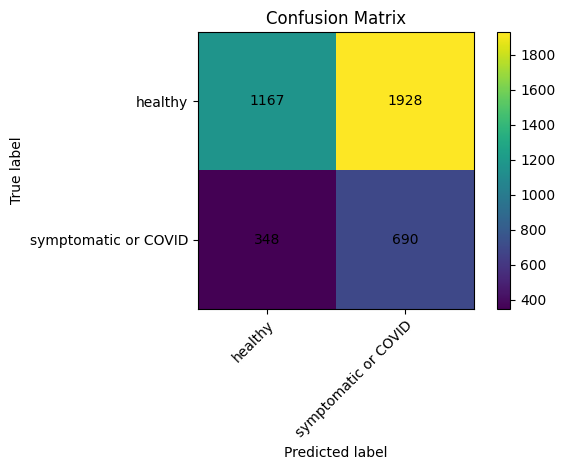

In [32]:
# === Evaluate the Model ===
# Get predictions from the model
y_pred = model.predict(X_test)  # Predict on X_test
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class predictions (argmax for the softmax output)

# Convert y_test from one-hot encoding to integer labels (healthy = 0, COVID/symptomatic = 1)
y_test_classes = np.argmax(y_test, axis=1)

# === Compute confusion matrix ===
cm = confusion_matrix(y_test_classes, y_pred_classes)

# === Print classification report ===
print("Classification Report:")
print(classification_report(
    y_test_classes,
    y_pred_classes,
    target_names=['healthy', 'symptomatic or COVID']
))

# === (Optional) Plot the confusion matrix ===
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

# Define the class labels
classes = ['healthy', 'symptomatic or COVID']
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Predicted label',
    ylabel='True label',
    title='Confusion Matrix'
)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate counts in each cell of the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()